In [1]:
%matplotlib inline

In [2]:
import sys, os
import numpy as np
import SimpleITK as sitk
import matplotlib.pylab as plt
import glob
plt.rcParams['figure.figsize'] = (8,6)

In [ ]:
ls 

Aggregate the moving image data, sort it, and put it into a single itk object.

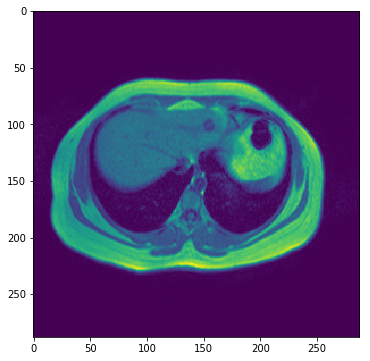

In [113]:
#dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/19/T2SPIR'
dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/19/T1DUAL'
moving_img_list = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/DICOM_anon/*dcm'))):
    #print(fn)
    if 'DUAL' in dataRoot:
        if i % 2 == 0:
            continue
    if i == 1:
        tmp_moving_image = sitk.ReadImage(fn)
    #print(sitk.ReadImage(fn).GetOrigin())
    #print(sitk.ReadImage(fn).GetSize())
    moving_img_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
plt.imshow(moving_img_list[22][0,:,:])
    
moving_image_series = np.zeros((len(moving_img_list),moving_img_list[0].shape[1], moving_img_list[0].shape[2] ), dtype=np.float32)
for i,img in enumerate(moving_img_list):
    moving_image_series[i,:,:] = img
    
moving_image = sitk.GetImageFromArray(moving_image_series)
moving_image.SetDirection(tmp_moving_image.GetDirection())
moving_image.SetOrigin(tmp_moving_image.GetOrigin())
moving_image.SetSpacing(tmp_moving_image.GetSpacing())

Do the same wrangling for the png segmentation images.

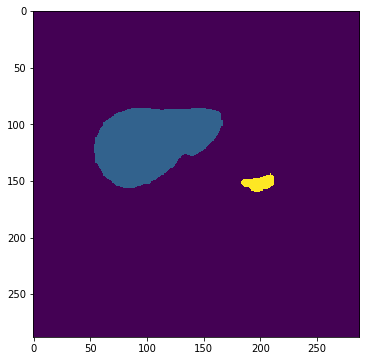

In [110]:
seg_image_list = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/Ground/*png'))):
    #print(fn)
    seg_image_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
    
plt.figure()
plt.imshow(seg_image_list[22][:,:])

seg_image= np.zeros((len(seg_image_list),seg_image_list[0].shape[0], seg_image_list[0].shape[1] ), dtype=np.float32)
for i,img in enumerate(seg_image_list):
    seg_image[i,:,:] = img
    
    
seg_image= sitk.GetImageFromArray(seg_image)
seg_image.SetDirection(tmp_moving_image.GetDirection())
seg_image.SetOrigin(tmp_moving_image.GetOrigin())
seg_image.SetSpacing(tmp_moving_image.GetSpacing())

Now lets get the fixed images from the MRE dataset

Reading Dicom directory: /pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/365/DICOM/ST00001
Image size: 256 256 4
Image dims: 1.6406 1.6406 10.0
(256, 256, 4)
(-211.99600219726562, -259.96099853515625, 88.50589752197266)


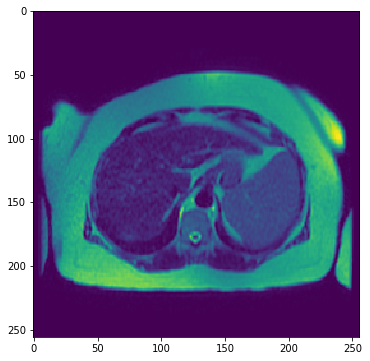

In [114]:
temp_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/365/DICOM/ST00001'
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
for fn in ['SE00001']:
    print( "Reading Dicom directory:", temp_data_dir )
    
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( temp_data_dir + '/' + fn )
    reader.SetFileNames(dicom_names)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    image = reader.Execute()
    size = image.GetSize()
    dims = image.GetSpacing()
    print( "Image size:", size[0], size[1], size[2] )
    print( "Image dims:", dims[0], dims[1], dims[2] )
fixed_image = image
fixed_image.GetPixelIDTypeAsString()
caster = sitk.CastImageFilter()
caster.SetOutputPixelType( sitk.sitkFloat32)
fixed_image = caster.Execute( fixed_image )
print(fixed_image.GetSize())
print(fixed_image.GetOrigin())
plt.imshow(sitk.GetArrayFromImage(fixed_image)[3])

Now let's interpolate everything so we're dealing with the same dimensions.

# Registration

Going to copy and paste in some methods from simpleITK notebook, attempt basic registration.

In [115]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img));
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [116]:
#import SimpleITK as sitk

#fixedImage = sitk.ReadImage('fixedImage.nii')
#movingImage = sitk.ReadImage('movingImage.nii')
parameterMapVector = sitk.VectorOfParameterMap()
paff = sitk.GetDefaultParameterMap("affine")
pbsp = sitk.GetDefaultParameterMap("bspline")
#paff['MaximumNumberOfIterations'] = ['512']
#pbsp['MaximumNumberOfIterations'] = ['512']
parameterMapVector.append(paff)
parameterMapVector.append(pbsp)
sitk.PrintParameterMap(parameterMapVector)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_image)
elastixImageFilter.SetMovingImage(moving_image)
elastixImageFilter.SetParameterMap(parameterMapVector)
elastixImageFilter.Execute()

resultImage = elastixImageFilter.GetResultImage()
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(resultImage));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [117]:
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(elastixImageFilter.GetTransformParameterMap())
transformixImageFilter.SetMovingImage(seg_image)
transformixImageFilter.Execute()
seg_result = transformixImageFilter.GetResultImage()


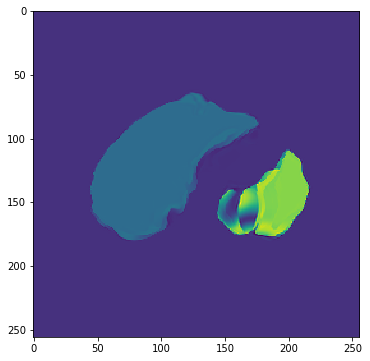

In [118]:
plt.imshow(sitk.GetArrayViewFromImage(seg_result[:,:,0]))

In [119]:
seg_result.SetOrigin(fixed_image.GetOrigin())
seg_image.SetOrigin(fixed_image.GetOrigin())
seg_image.SetSpacing(fixed_image.GetSpacing())

In [120]:
#interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(seg_image));
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(resultImage), moving=fixed(seg_result));
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(seg_result));
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(resultImage));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [11]:
#sitk.PrintParameterMap(transformParameterMap)
#for i in transformParameterMap: print(i)

In [ ]:
#trans, final_trans, registration_method = reg_func(fixed_image, moving_image, 1)

In [47]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.1579690487796368
Optimizer's stopping condition, LBFGSBOptimizerv4: Gradient tolerance reached. Gradient tolerance is 1e-06


In [48]:
moving_resampled = sitk.Resample(moving_image, fixed_image, trans, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

moving_resampled = sitk.Resample(moving_image, fixed_image, final_trans, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

seg_resampled = sitk.Resample(seg_image, fixed_image, trans, sitk.sitkLinear, 0.0, seg_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(seg_resampled));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))